# COCS2673 Assignment 2 P1A - Is or is not cancel prediction

## Tasks
### Load Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

# Classifiy if image is cancer or not

Use base of the VGG network and adapt to our platform
Reference: [VGG paper](https://arxiv.org/abs/1409.1556)


# Load Data and EDA

In [1]:
import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

In [2]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [3]:
mainData = mainData.append(extraData, ignore_index=True)
#mainData = mainData.sample(2000)


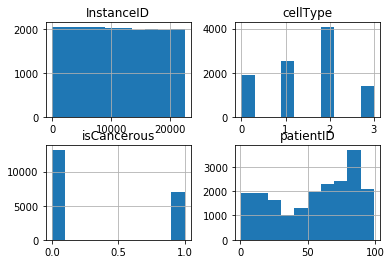

In [4]:
mainData.hist()
plt.show()

In [5]:
neg, pos = np.bincount(mainData.isCancerous)
total = neg + pos
print('Class Data:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Class Data:
    Total: 20280
    Positive: 7069 (34.86% of total)



#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)

Split of benign to cancerous is a 35% cancerous, 65% benign

In [6]:
mainData['Class'] = mainData['isCancerous'].astype('str')
mainData.drop(['InstanceID'], axis = 1, inplace=True)   # , 'cellTypeName', 'cellType'


In [7]:
print(mainData.shape)
print(mainData.info())
print(mainData.describe())
mainData.head()

(20280, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20280 entries, 0 to 20279
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientID     20280 non-null  int64  
 1   ImageName     20280 non-null  object 
 2   cellTypeName  9896 non-null   object 
 3   cellType      9896 non-null   float64
 4   isCancerous   20280 non-null  int64  
 5   Class         20280 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 950.8+ KB
None
          patientID     cellType   isCancerous
count  20280.000000  9896.000000  20280.000000
mean      55.681065     1.501516      0.348570
std       28.891837     0.954867      0.476529
min        1.000000     0.000000      0.000000
25%       29.000000     1.000000      0.000000
50%       63.000000     2.000000      0.000000
75%       81.000000     2.000000      1.000000
max       99.000000     3.000000      1.000000


,patientID,ImageName,cellTypeName,cellType,isCancerous,Class
0,1,22405.png,fibroblast,0.0,0,0
1,1,22406.png,fibroblast,0.0,0,0
2,1,22407.png,fibroblast,0.0,0,0
3,1,22408.png,fibroblast,0.0,0,0
4,1,22409.png,fibroblast,0.0,0,0


In [8]:
# Quick check to make sure images are unique
mainData.groupby('ImageName').filter(lambda group: len(group) > 1)  

,patientID,ImageName,cellTypeName,cellType,isCancerous,Class


### Split on Patients

In [9]:
# Get list of patients and observation counts
TEST_RATIO = 0.2
VAL_RATIO = 0.2


In [23]:
np.random.seed(43) # Consistent random list

recCount = mainData.shape[0]
custRec = mainData.patientID.value_counts().to_dict()
    
patientIds = list(custRec.keys())
    
testCust = []
testRecs = 0
while (testRecs < (recCount * TEST_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    testCust.append(pId)
    testRecs += ic
    
#print(testCust, testRecs)

valCust = []
valRecs = 0
while (valRecs < (recCount * VAL_RATIO)):
    pId = np.random.choice(patientIds)
    ic = custRec.get(pId)
    patientIds.remove(pId)
    valCust.append(pId)
    valRecs += ic

#print(valCust, valRecs)

In [24]:
testData = mainData[mainData.patientID.isin(testCust)]
valData = mainData[mainData.patientID.isin(valCust)]
trainData = mainData[~(mainData.patientID.isin(valCust + testCust))]

In [25]:
#print(trainData.shape[0] + valData.shape[0] + testData.shape[0])
#print(mainData.shape[0])
print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))

Train data : 11900, Val Data: 4278, Test Data: 4102


In [26]:
trainData['Class'] = trainData['isCancerous'].astype('str')
valData['Class'] = valData['isCancerous'].astype('str')
testData['Class'] = testData['isCancerous'].astype('str')

C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

# Images

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 11700 validated image filenames belonging to 2 classes.
Found 4199 validated image filenames belonging to 2 classes.


# Model development

- Start initially on a model based on VGG
- Reference: [VGG paper](https://arxiv.org/abs/1409.1556)

In [15]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1 # flag

In [16]:
import tensorflow as tf

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

**Observations:**
- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions. 
- activation is ReLU

Lets compile the model and fit.

In [29]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [30]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

22:09:01


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'], 'r--')
plt.plot(history.history['val_binary_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryCrossentropy())
              # metrics=tf.keras.metrics.Recall())

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.Recall())

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)